In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score
)
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

from venn_abers import VennAbersCalibrator
from mapie.metrics.calibration import expected_calibration_error

In [9]:
def _logit(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log(1 - p)

def platt_fit_predict(s_cal, y_cal, s_test, l2=1e-6):
    z = _logit(s_cal)
    def nll(ab):
        A, B = ab
        p = 1.0 / (1.0 + np.exp(-(A * z + B)))
        return log_loss(y_cal, p) + l2 * (A*A + B*B)
    res = minimize(nll, x0=np.array([1.0, 0.0]), method="L-BFGS-B")
    A_opt, B_opt = res.x
    z_test = _logit(s_test)
    p_test = 1.0 / (1.0 + np.exp(-(A_opt * z_test + B_opt)))
    return p_test, (A_opt, B_opt, res)

def ece_quantile(y, p, n_bins=10):
    pt, pp = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return expected_calibration_error(y, p, num_bins=n_bins, split_strategy="quantile"), pt, pp

# def ece_quantile(y, p, n_bins=10):
#     return expected_calibration_error(y, p, num_bins=n_bins, split_strategy="quantile")


In [36]:
def run_simulation(counts, title="Simulation"):
    rng = np.random.default_rng(42)


    # Class 0: mixture of two Betas(2,5) and (1,8)
    probs_0 = 0.7 * rng.beta(3, 5, size=counts[0]) + 0.3 * rng.beta(1, 8, size=counts[0]) * rng.choice([-1, 1], size=counts[0])
    probs_0 = np.clip(probs_0, 0, 1)
    
    rng = np.random.default_rng(0)
    # Class 1: mixture of two Betas(10,5) and (1,8)
    probs_1 = 0.7 * rng.beta(10, 5, size=counts[1]) + 0.3 * rng.beta(1, 8, size=counts[1]) * rng.choice([-1, 1], size=counts[1])
    probs_1 = np.clip(probs_1, 0, 1)

    df_sim = pd.DataFrame({
        "y": np.concatenate([np.zeros(counts[0], int), np.ones(counts[1], int)]),
        "proba": np.concatenate([probs_0, probs_1])
    }).sample(frac=1, random_state=42).reset_index(drop=True)

    plt.figure(figsize=(8,5))
    sns.histplot(df_sim[df_sim["y"]==0]["proba"], bins=30, color="blue", label="Class 0", stat="density", alpha=0.5)
    sns.histplot(df_sim[df_sim["y"]==1]["proba"], bins=30, color="red", label="Class 1", stat="density", alpha=0.5)

    sns.kdeplot(df_sim[df_sim["y"]==0]["proba"], color="blue", lw=2)
    sns.kdeplot(df_sim[df_sim["y"]==1]["proba"], color="red", lw=2)

    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.title(f"Simulated Probabilities by Class {title}")
    plt.legend()
    plt.show()

    # print(f"\n=== {title} ===")
    # print(df_sim.groupby("y")["proba"].describe())

    # ---- Calibration split ----
    X_cal, X_test, y_cal, y_test = train_test_split(
        df_sim[["proba"]].values, df_sim["y"].values,
        test_size=0.3, stratify=df_sim["y"].values, random_state=42
    )
    s_cal, s_test = X_cal.ravel(), X_test.ravel()

    # ---- Platt ----
    p_platt_test, _ = platt_fit_predict(s_cal, y_cal, s_test)
    p_platt_cal, _  = platt_fit_predict(s_cal, y_cal, s_cal)

    # ---- Isotonic ----
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(s_cal, y_cal)
    p_iso_test, p_iso_cal = iso.predict(s_test), iso.predict(s_cal)

    # ---- Venn-Abers ----
    p_cal_2d  = np.column_stack([1 - s_cal,  s_cal])
    p_test_2d = np.column_stack([1 - s_test, s_test])
    va = VennAbersCalibrator()
    p_va_test = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                 p_test=p_test_2d, p0_p1_output=False)[:,1]
    p_va_cal = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                p_test=p_cal_2d, p0_p1_output=False)[:,1]

    # ---- Results ----
    methods_test = {
        "Raw": s_test,
        "Platt": p_platt_test,
        "Isotonic": p_iso_test,
        "Venn-Abers-IVAP": p_va_test,
    }
    methods_cal = {
        "Raw": s_cal,
        "Platt": p_platt_cal,
        "Isotonic": p_iso_cal,
        "Venn-Abers-IVAP": p_va_cal,
    }

    def evaluate(methods, y, setname):
        rows = []
        for name, p in methods.items():
            ece, _, _ = ece_quantile(y, p, n_bins=10)
            rows.append({
                "Method": name,
                "LogLoss": log_loss(y, p),
                "Brier": brier_score_loss(y, p),
                "ROC_AUC": roc_auc_score(y, p),
                "ECE": ece,
            })
        df = pd.DataFrame(rows).set_index("Method").round(4)
        print(f"\nCalibration Metrics ({setname} set):")
        display(df)

    # --- Metrics ---
    evaluate(methods_cal,  y_cal,  "Calibration")
    evaluate(methods_test, y_test, "Test")

    # --- Calibration curves: CAL set ---
    plt.figure(figsize=(6,6))
    max_pp = []
    max_pt = []
    for name, p in methods_cal.items():
        _, pt, pp = ece_quantile(y_cal, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
        max_pp.append(max(pp))
        max_pt.append(max(pt))

    plt.plot([0,max(max(max_pp), max(max_pt))],[0,max(max(max_pp), max(max_pt))],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Calibration set) - {title}")
    plt.legend(); plt.grid(True); plt.show()

    # --- Calibration curves: TEST set ---
    plt.figure(figsize=(6,6))
    max_pp = []
    max_pt = []
    for name, p in methods_test.items():
        _, pt, pp = ece_quantile(y_test, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
        max_pp.append(max(pp))
        max_pt.append(max(pt))

    plt.plot([0,max(max(max_pp), max(max_pt))],[0,max(max(max_pp), max(max_pt))],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Test set) - {title}")
    plt.legend(); plt.grid(True); plt.show()


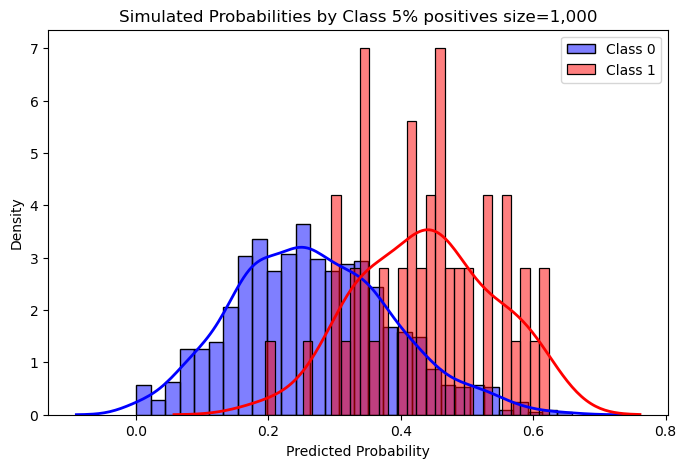


Calibration Metrics (Calibration set):


c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3516,0.0977,0.8547,0.2257
Platt,0.1533,0.0415,0.8547,0.0069
Isotonic,0.1426,0.0387,0.8724,0.0000
Venn-Abers-IVAP,0.1494,0.0394,0.8668,0.0126



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3548,0.0985,0.8735,0.2285
Platt,0.1543,0.0435,0.8735,0.0180
Isotonic,0.1543,0.0453,0.8789,0.0179
Venn-Abers-IVAP,0.1613,0.0454,0.8791,0.0259


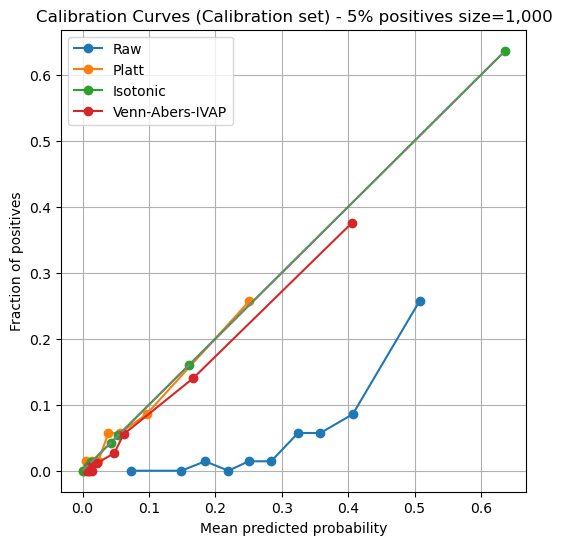

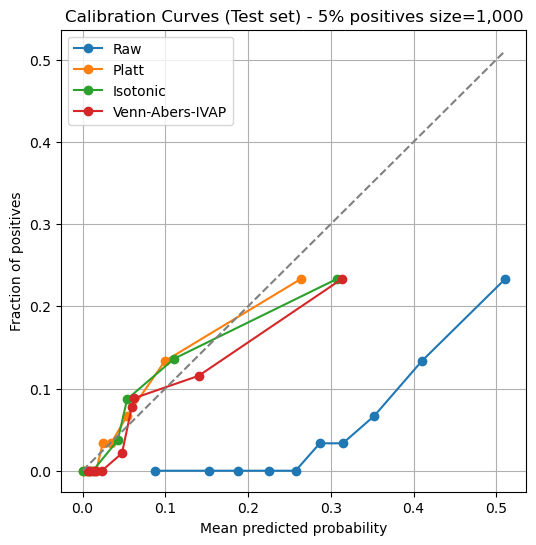

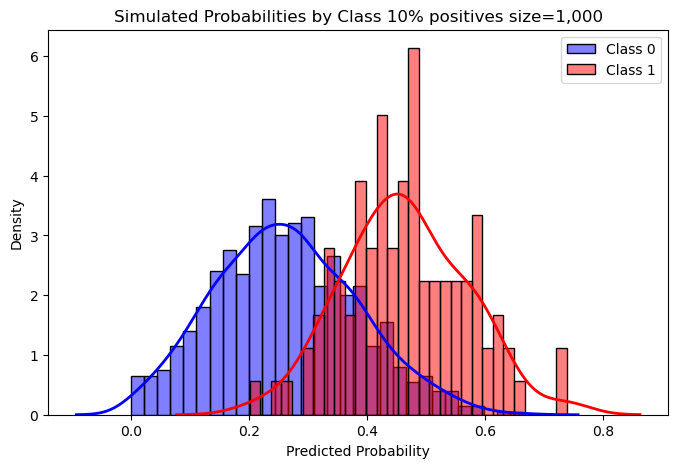


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3648,0.1040,0.8965,0.1830
Platt,0.2117,0.0633,0.8965,0.0073
Isotonic,0.2025,0.0611,0.9055,0.0000
Venn-Abers-IVAP,0.2101,0.0619,0.9028,0.0145



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3735,0.1083,0.8863,0.1844
Platt,0.2269,0.0715,0.8863,0.0192
Isotonic,0.2288,0.0726,0.8822,0.0252
Venn-Abers-IVAP,0.2316,0.0720,0.8871,0.0276


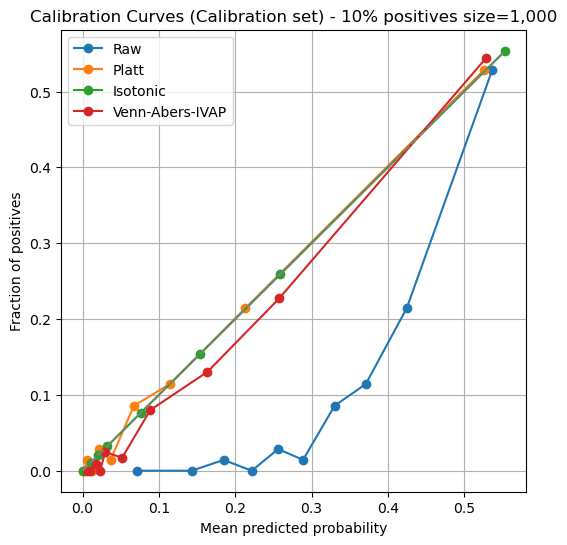

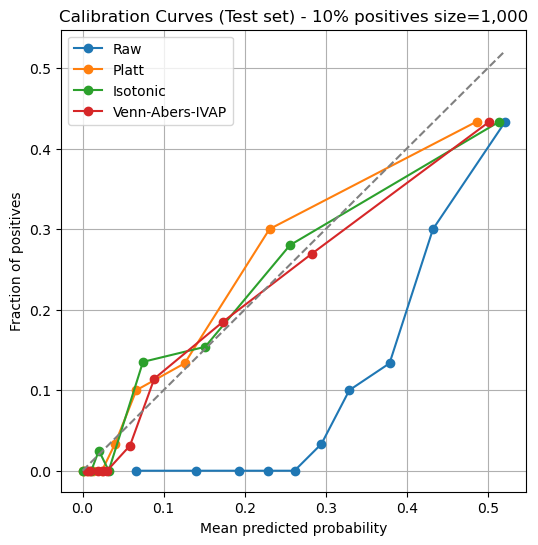

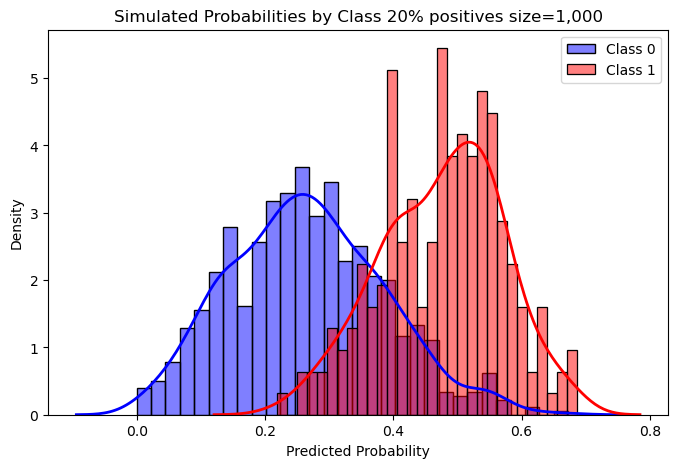


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4073,0.1232,0.9131,0.1607
Platt,0.2856,0.0908,0.9131,0.0158
Isotonic,0.2677,0.0856,0.9200,0.0000
Venn-Abers-IVAP,0.2777,0.0867,0.9184,0.0154



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4195,0.1275,0.9047,0.1693
Platt,0.3105,0.0972,0.9047,0.0403
Isotonic,0.7526,0.0979,0.8979,0.0382
Venn-Abers-IVAP,0.3124,0.0966,0.9029,0.0411


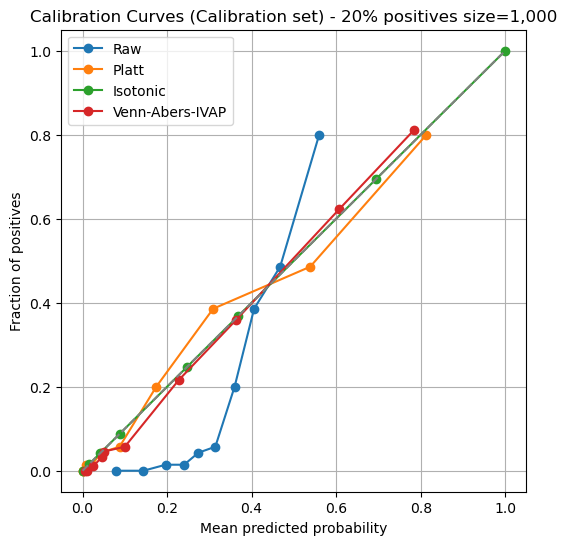

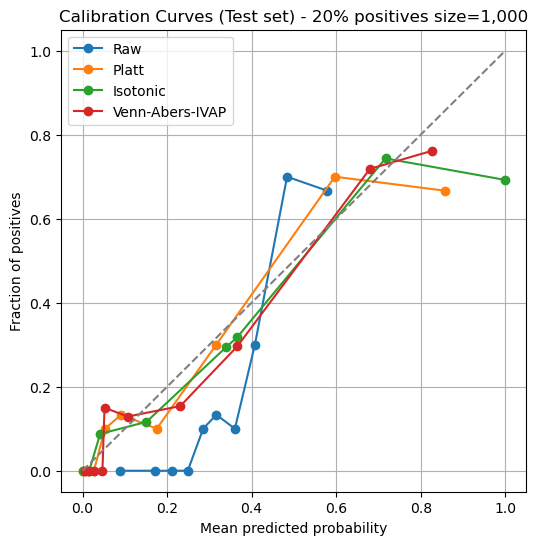

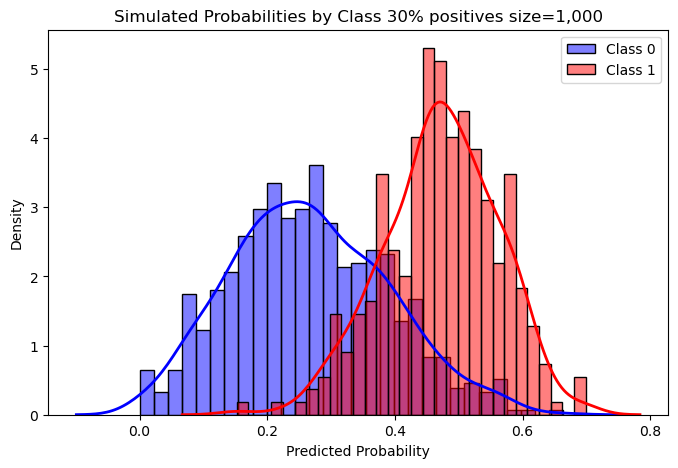


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4602,0.1468,0.9057,0.1633
Platt,0.3550,0.1129,0.9057,0.0328
Isotonic,0.3335,0.1063,0.9129,0.0000
Venn-Abers-IVAP,0.3404,0.1073,0.9113,0.0155



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4558,0.1454,0.9061,0.1629
Platt,0.3474,0.1147,0.9061,0.0481
Isotonic,0.3490,0.1167,0.9068,0.0398
Venn-Abers-IVAP,0.3536,0.1165,0.9078,0.0667


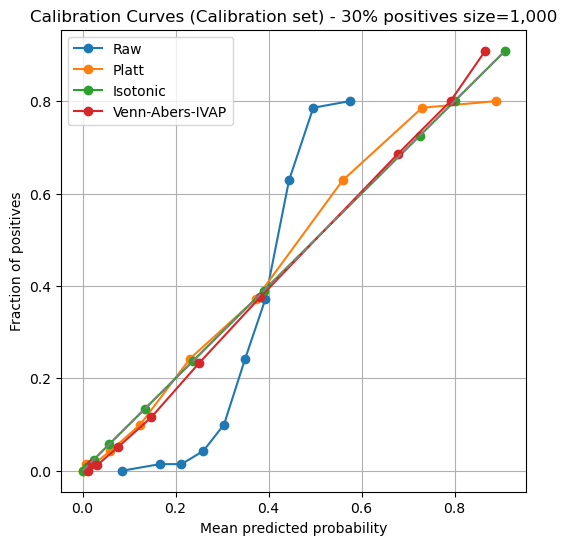

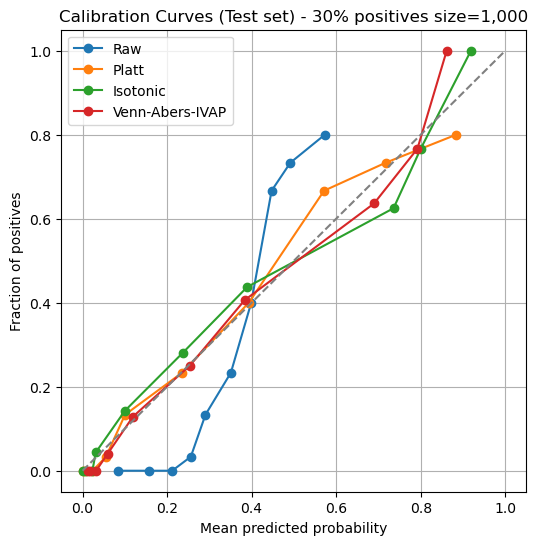

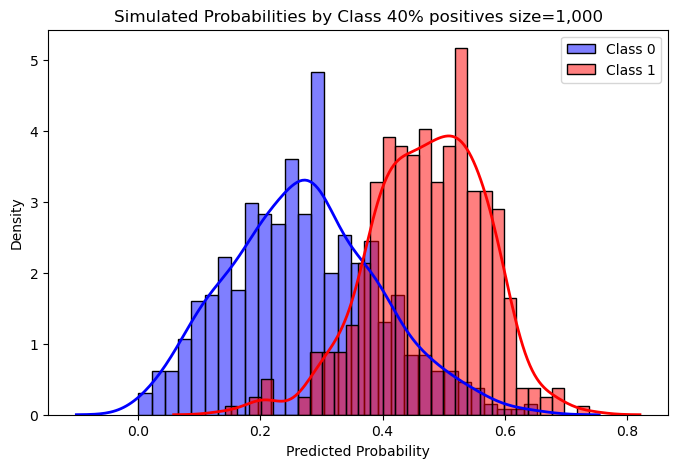


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5090,0.1681,0.8984,0.1920
Platt,0.3954,0.1251,0.8984,0.0282
Isotonic,0.3765,0.1200,0.9045,0.0000
Venn-Abers-IVAP,0.3836,0.1210,0.9032,0.0186



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5041,0.1667,0.9110,0.1992
Platt,0.3776,0.1189,0.9110,0.0601
Isotonic,0.3715,0.1179,0.9101,0.0445
Venn-Abers-IVAP,0.3737,0.1176,0.9110,0.0494


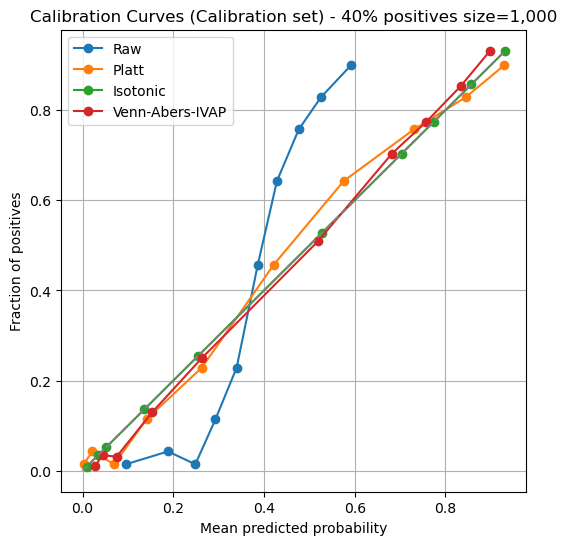

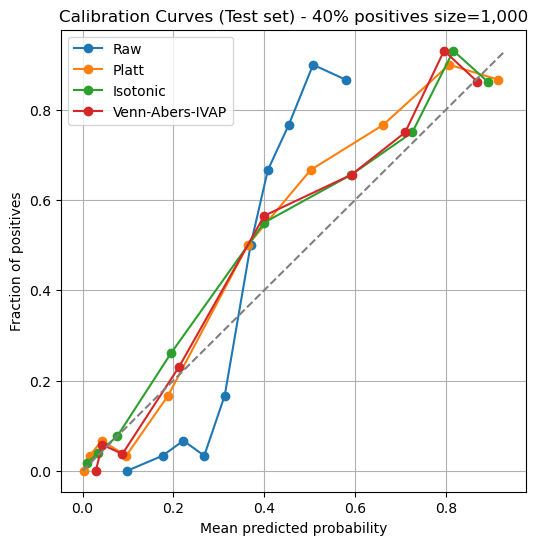

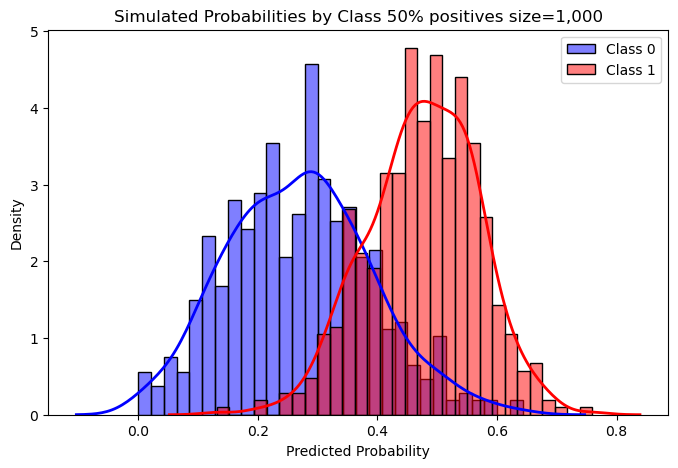


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5475,0.1859,0.9109,0.2285
Platt,0.3751,0.1168,0.9109,0.0319
Isotonic,0.3517,0.1107,0.9173,0.0000
Venn-Abers-IVAP,0.3592,0.1118,0.9160,0.0164



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5427,0.1835,0.9102,0.2181
Platt,0.3799,0.1188,0.9102,0.0292
Isotonic,0.5019,0.1213,0.9082,0.0564
Venn-Abers-IVAP,0.3795,0.1194,0.9115,0.0448


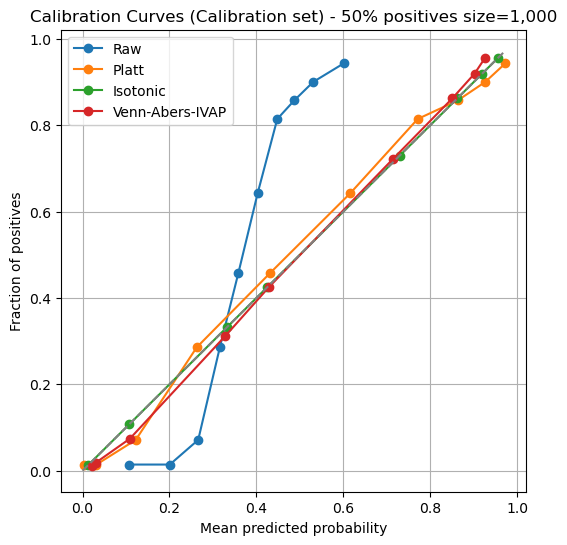

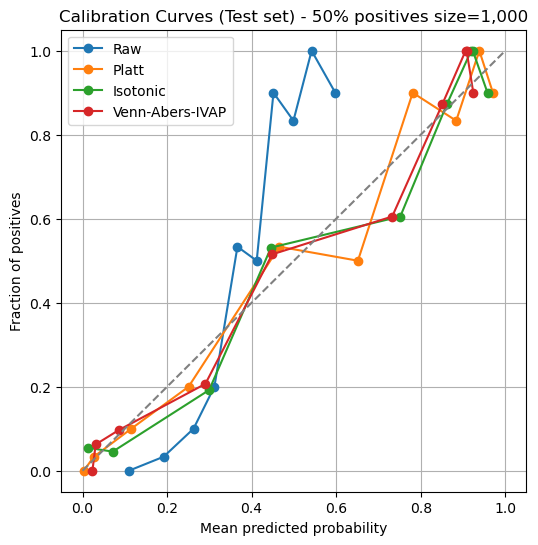

In [39]:
# Size of dataset: 1,000 samples
run_simulation({0: 950, 1: 50}, title="5% positives size=1,000")

run_simulation({0: 900, 1: 100}, title="10% positives size=1,000")

run_simulation({0: 800, 1: 200}, title="20% positives size=1,000")

run_simulation({0: 700, 1: 300}, title="30% positives size=1,000")

run_simulation({0: 600, 1: 400}, title="40% positives size=1,000")

run_simulation({0: 500, 1: 500}, title="50% positives size=1,000")


# # Balanced (equal classes)
# run_simulation({0: 10000, 1: 10000}, title="Balanced classes")

# # Reversed imbalance (1 >> 0)
# run_simulation({0: 7108, 1: 25473}, title="Reversed imbalance")


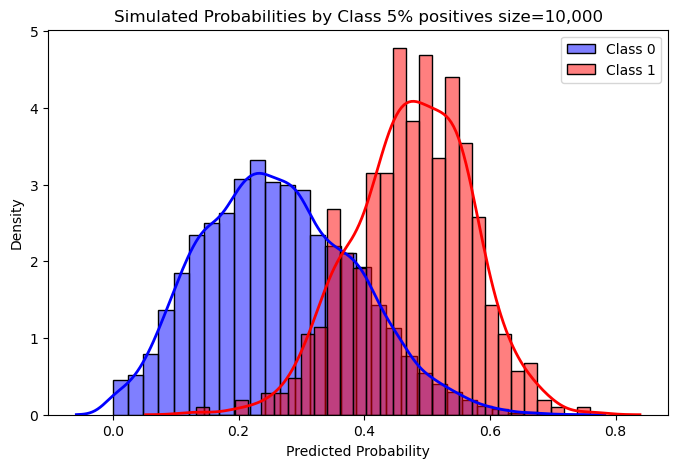


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3422,0.0937,0.9199,0.2247
Platt,0.1284,0.0370,0.9199,0.0022
Isotonic,0.1245,0.0361,0.9227,0.0000
Venn-Abers-IVAP,0.1256,0.0362,0.9221,0.0026



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3445,0.0952,0.8948,0.2235
Platt,0.1419,0.0402,0.8948,0.0101
Isotonic,0.1501,0.0397,0.8954,0.0085
Venn-Abers-IVAP,0.1405,0.0397,0.8948,0.0099


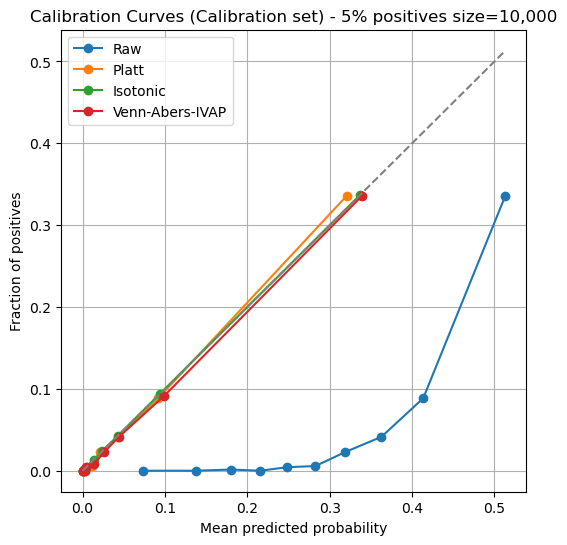

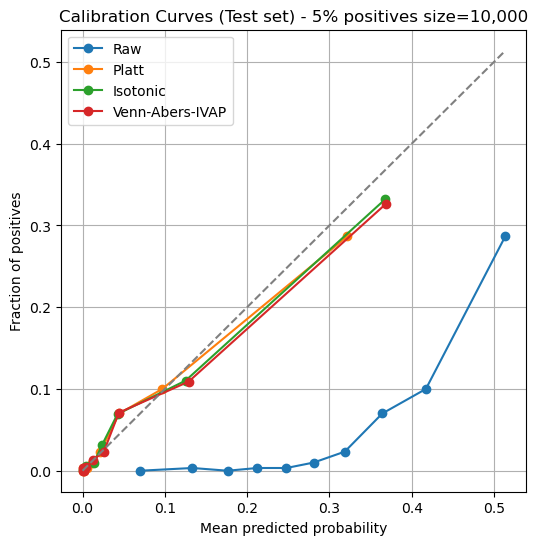

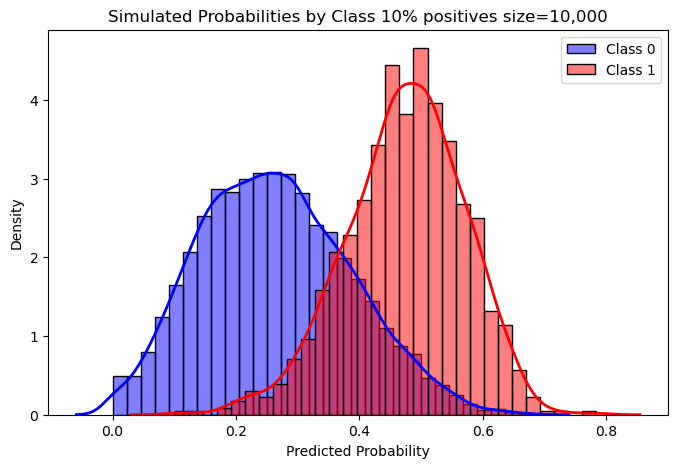


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3658,0.1045,0.9057,0.1847
Platt,0.2078,0.0630,0.9057,0.0048
Isotonic,0.2030,0.0617,0.9083,0.0000
Venn-Abers-IVAP,0.2040,0.0618,0.9078,0.0030



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3637,0.1036,0.9131,0.1840
Platt,0.2001,0.0608,0.9131,0.0096
Isotonic,0.2021,0.0613,0.9121,0.0081
Venn-Abers-IVAP,0.2016,0.0612,0.9125,0.0075


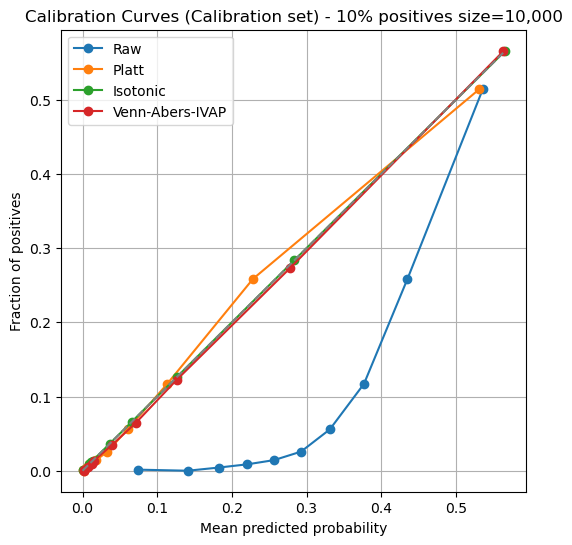

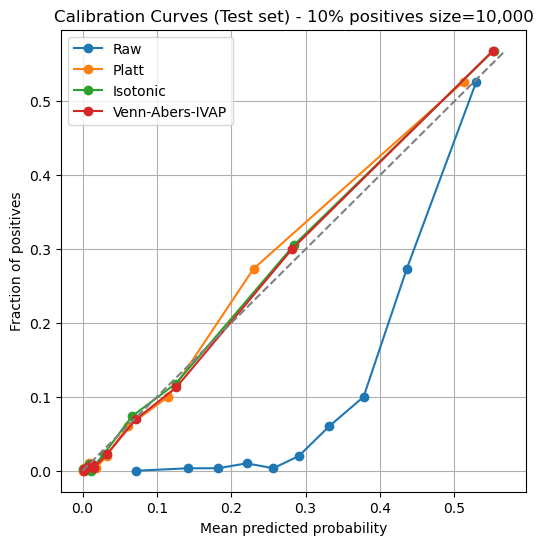

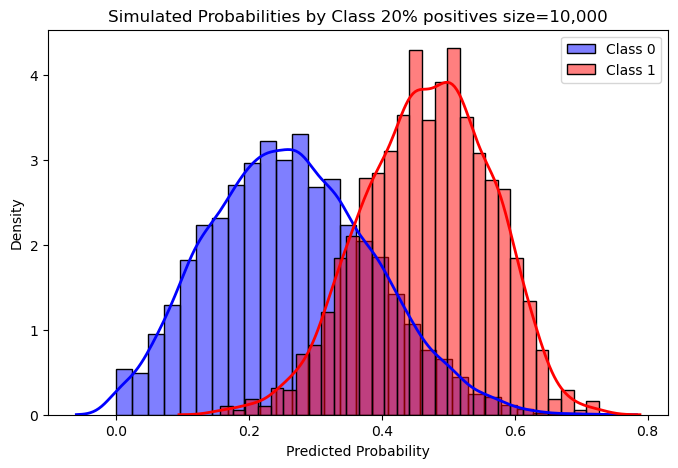


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4132,0.1258,0.9037,0.1582
Platt,0.3021,0.0962,0.9037,0.0068
Isotonic,0.2974,0.0951,0.9054,0.0000
Venn-Abers-IVAP,0.2984,0.0953,0.9051,0.0033



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4121,0.1256,0.9006,0.1561
Platt,0.3085,0.0982,0.9006,0.0216
Isotonic,0.3082,0.0982,0.8998,0.0135
Venn-Abers-IVAP,0.3076,0.0981,0.9004,0.0139


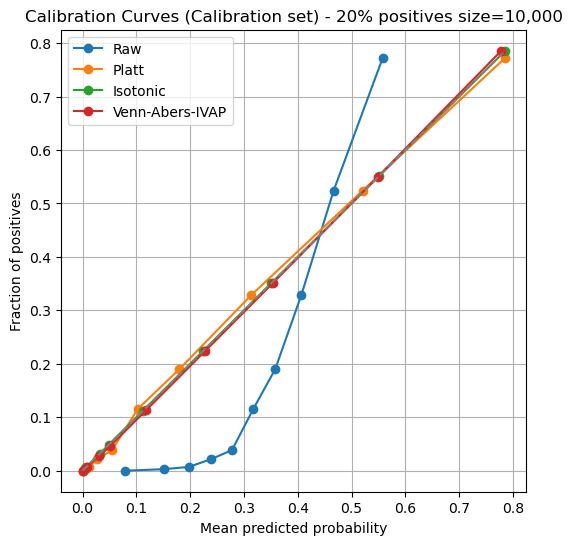

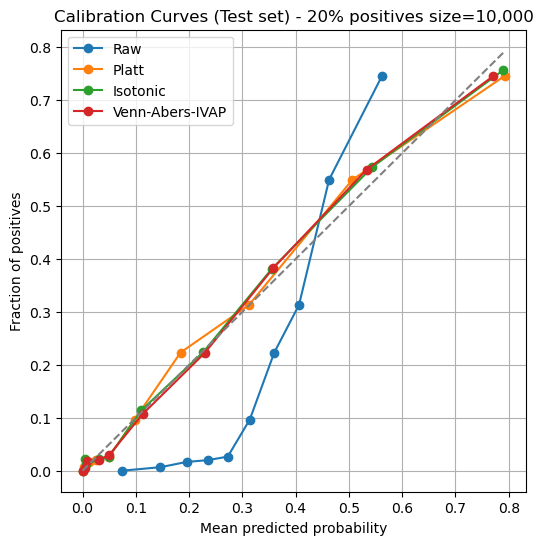

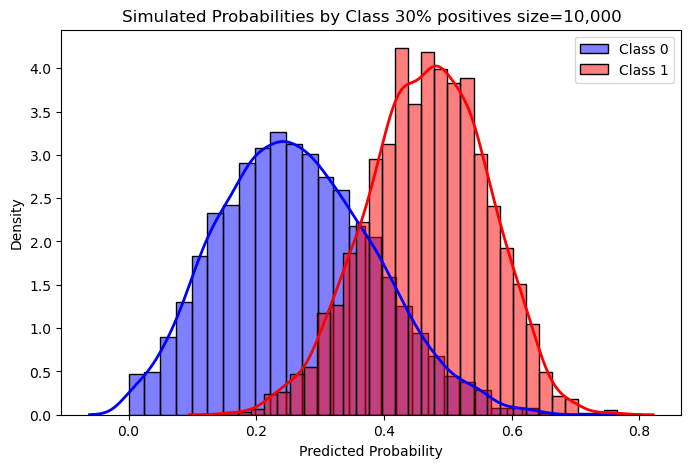


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4597,0.1468,0.9032,0.1633
Platt,0.3568,0.1151,0.9032,0.0143
Isotonic,0.3512,0.1137,0.9047,0.0000
Venn-Abers-IVAP,0.3524,0.1138,0.9045,0.0038



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4562,0.1453,0.9091,0.1660
Platt,0.3465,0.1117,0.9091,0.0155
Isotonic,0.3459,0.1120,0.9086,0.0093
Venn-Abers-IVAP,0.3467,0.1121,0.9086,0.0095


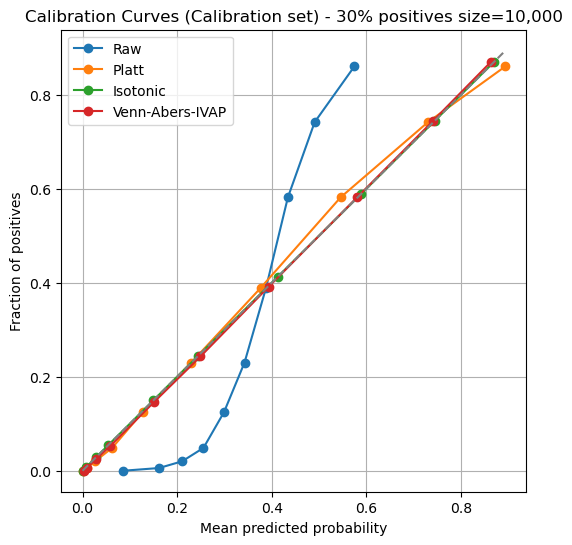

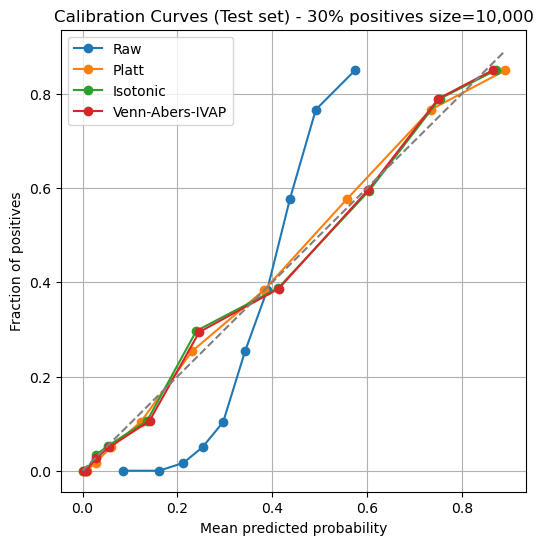

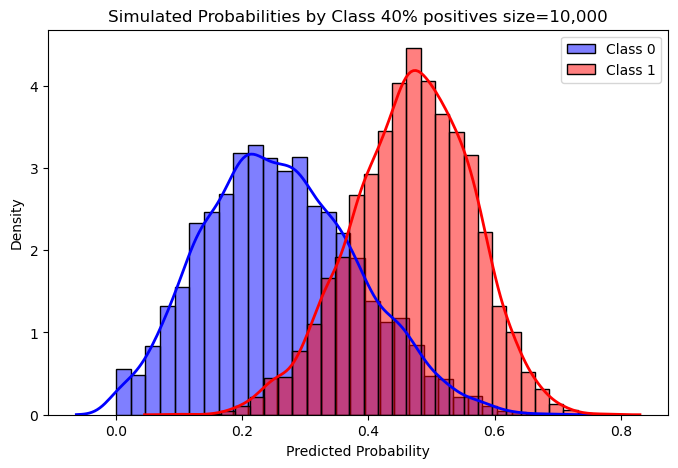


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5045,0.1671,0.9030,0.1823
Platt,0.3835,0.1233,0.9030,0.0129
Isotonic,0.3778,0.1218,0.9047,0.0000
Venn-Abers-IVAP,0.3788,0.1220,0.9045,0.0039



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4989,0.1646,0.9128,0.1957
Platt,0.3655,0.1165,0.9128,0.0214
Isotonic,0.3669,0.1171,0.9121,0.0138
Venn-Abers-IVAP,0.3674,0.1172,0.9124,0.0158


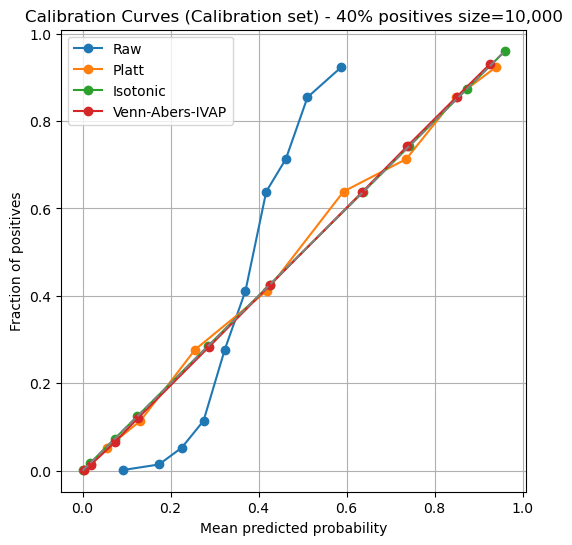

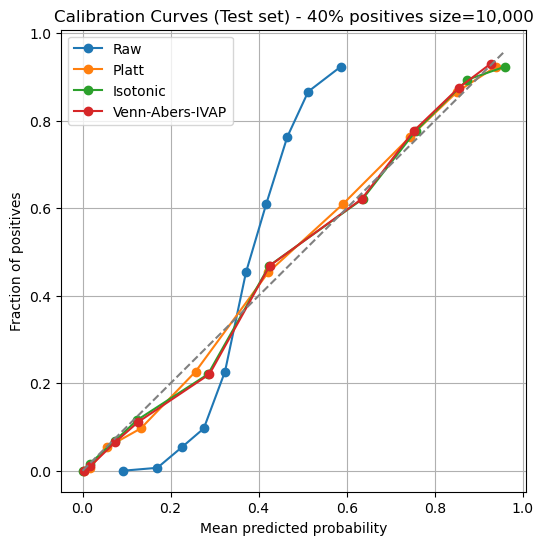

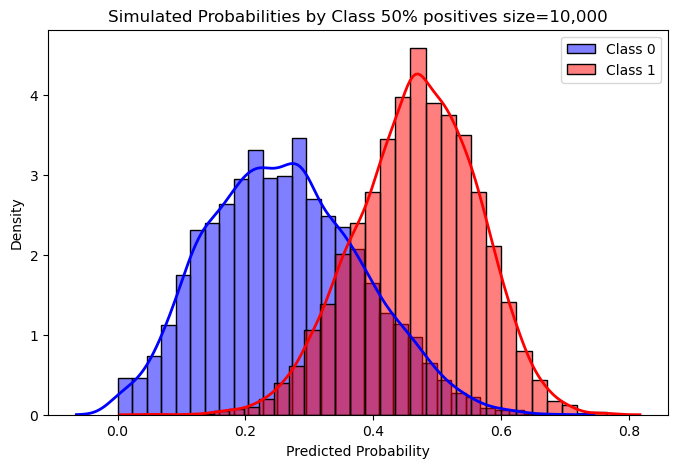


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5451,0.1853,0.9140,0.2287
Platt,0.3677,0.1165,0.9140,0.0096
Isotonic,0.3627,0.1153,0.9154,0.0000
Venn-Abers-IVAP,0.3639,0.1154,0.9153,0.0042



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5572,0.1907,0.8967,0.2206
Platt,0.4024,0.1283,0.8967,0.0173
Isotonic,0.4238,0.1285,0.8964,0.0157
Venn-Abers-IVAP,0.4021,0.1284,0.8965,0.0139


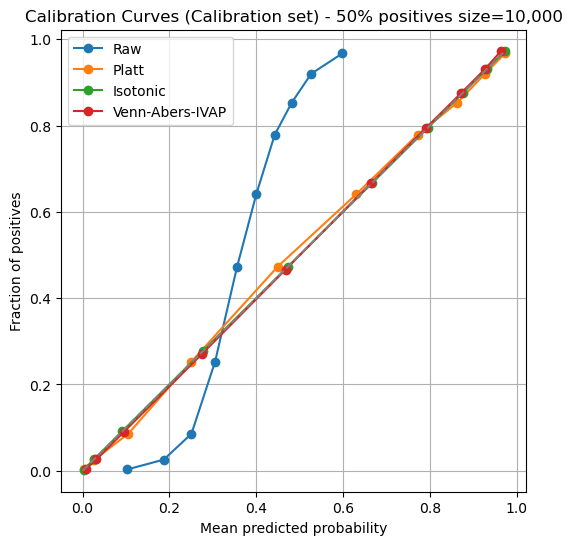

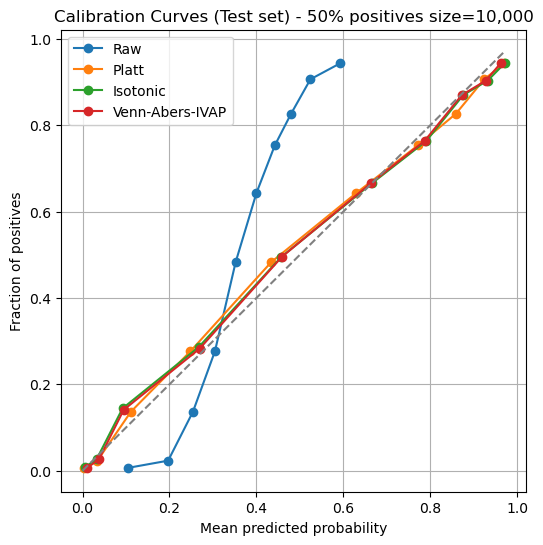

In [41]:
# Size of dataset: 10,000 samples
run_simulation({0: 9500, 1: 500}, title="5% positives size=10,000")

run_simulation({0: 9000, 1: 1000}, title="10% positives size=10,000")

run_simulation({0: 8000, 1: 2000}, title="20% positives size=10,000")

run_simulation({0: 7000, 1: 3000}, title="30% positives size=10,000")

run_simulation({0: 6000, 1: 4000}, title="40% positives size=10,000")

run_simulation({0: 5000, 1: 5000}, title="50% positives size=10,000")


# # Balanced (equal classes)
# run_simulation({0: 10000, 1: 10000}, title="Balanced classes")

# # Reversed imbalance (1 >> 0)
# run_simulation({0: 7108, 1: 25473}, title="Reversed imbalance")


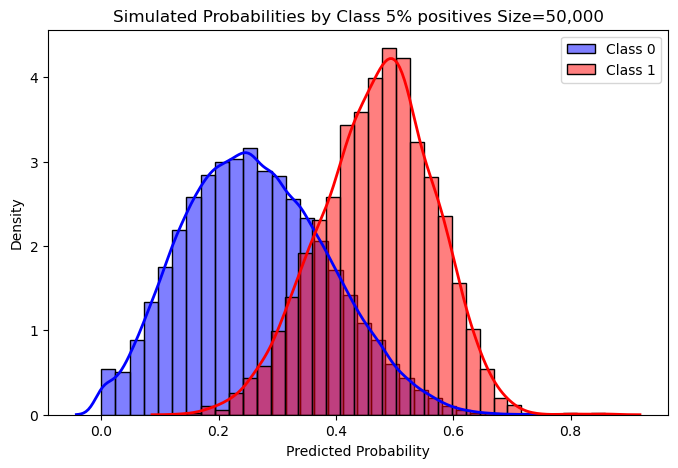


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3436,0.0945,0.9048,0.2241
Platt,0.1349,0.0382,0.9048,0.0016
Isotonic,0.1333,0.0378,0.9062,0.0000
Venn-Abers-IVAP,0.1336,0.0379,0.9060,0.0009



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3455,0.0955,0.8958,0.2248
Platt,0.1387,0.0389,0.8958,0.0035
Isotonic,0.1386,0.0387,0.8951,0.0041
Venn-Abers-IVAP,0.1385,0.0387,0.8952,0.0043


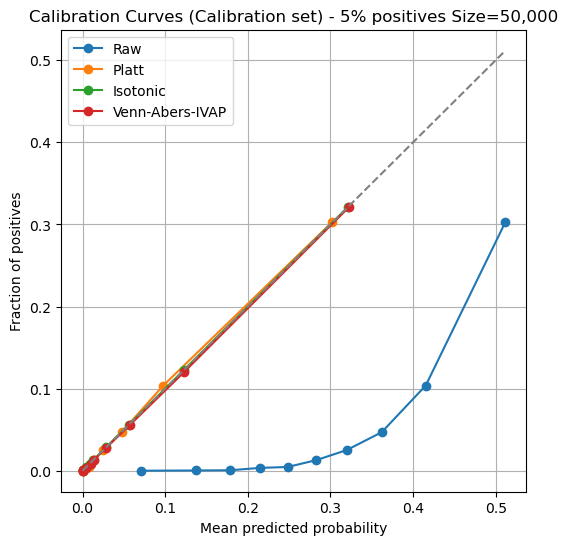

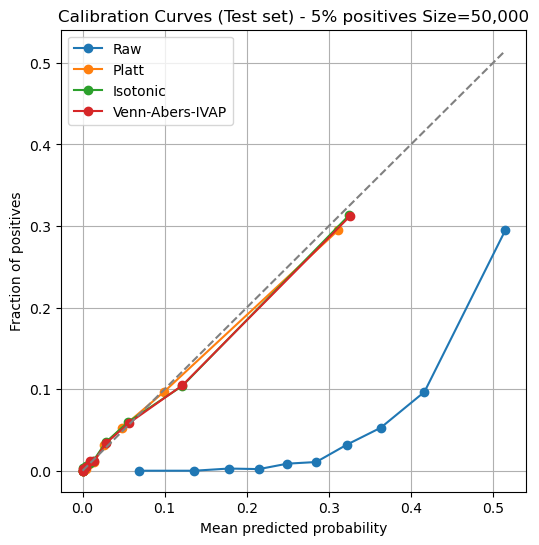

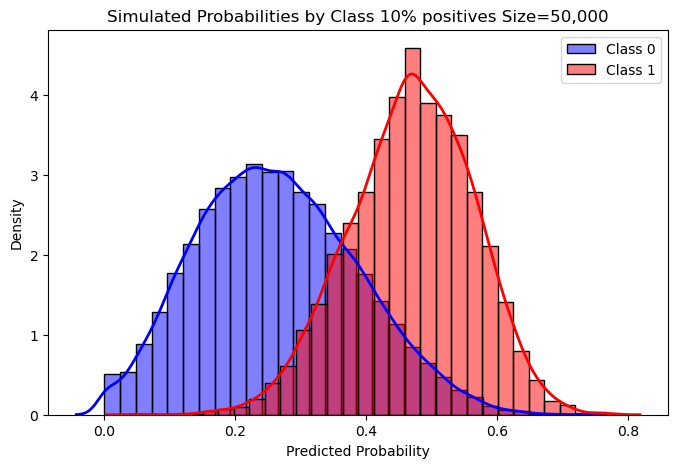


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3666,0.1049,0.9033,0.1841
Platt,0.2100,0.0642,0.9033,0.0055
Isotonic,0.2078,0.0637,0.9042,0.0000
Venn-Abers-IVAP,0.2081,0.0637,0.9041,0.0010



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3674,0.1053,0.9020,0.1848
Platt,0.2104,0.0639,0.9020,0.0054
Isotonic,0.2125,0.0639,0.9013,0.0064
Venn-Abers-IVAP,0.2106,0.0639,0.9013,0.0060


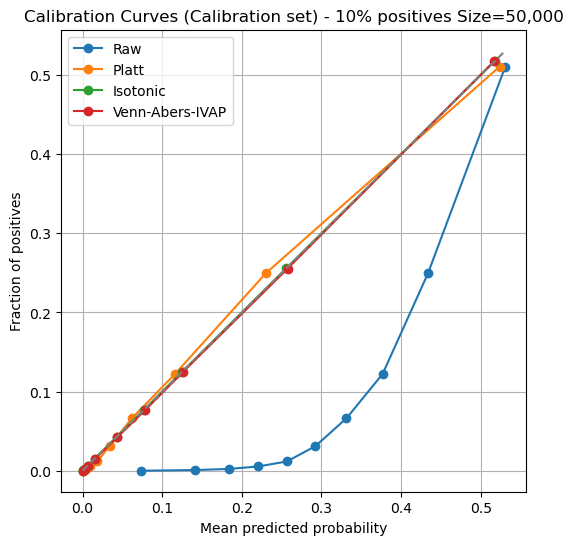

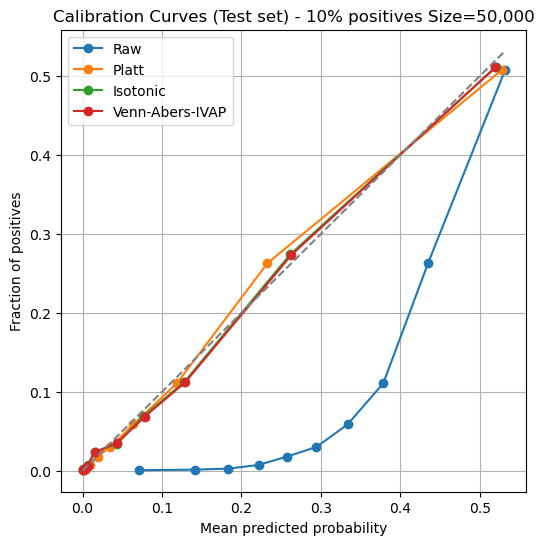

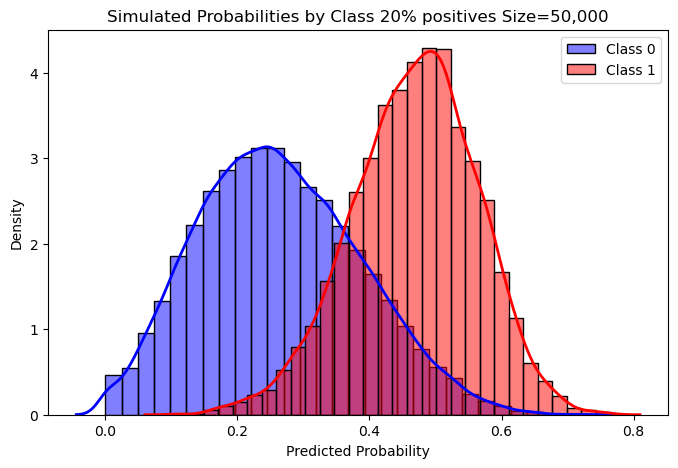


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4124,0.1257,0.9007,0.1548
Platt,0.3065,0.0977,0.9007,0.0089
Isotonic,0.3038,0.0970,0.9014,0.0000
Venn-Abers-IVAP,0.3040,0.0970,0.9014,0.0011



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4144,0.1263,0.9023,0.1575
Platt,0.3050,0.0973,0.9023,0.0106
Isotonic,0.3062,0.0972,0.9022,0.0048
Venn-Abers-IVAP,0.3042,0.0972,0.9022,0.0052


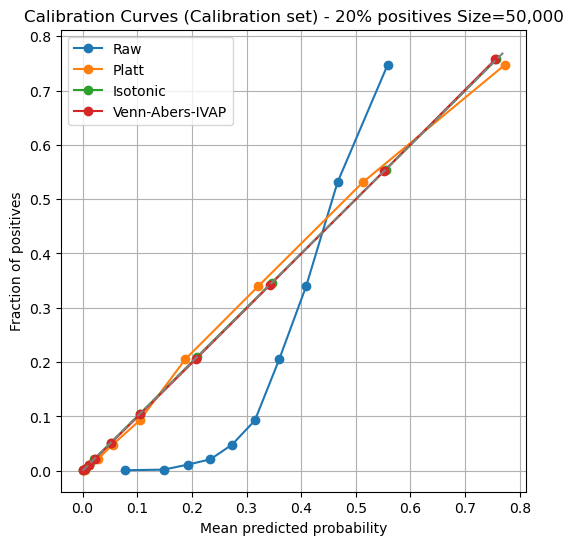

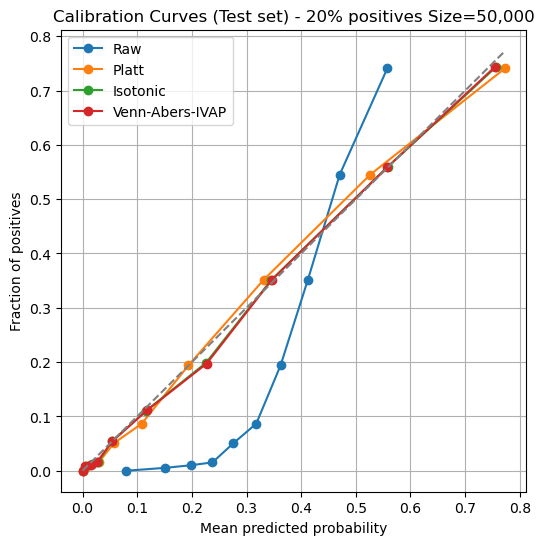

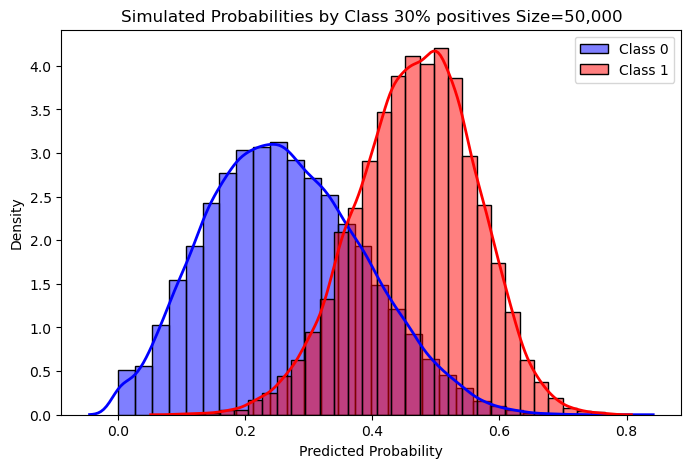

c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:



Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4578,0.1462,0.9041,0.1615
Platt,0.3551,0.1146,0.9041,0.0126
Isotonic,0.3521,0.1139,0.9047,0.0000
Venn-Abers-IVAP,0.3523,0.1140,0.9046,0.0012



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4597,0.1469,0.9006,0.1575
Platt,0.3611,0.1163,0.9006,0.0109
Isotonic,0.3604,0.1162,0.9003,0.0049
Venn-Abers-IVAP,0.3603,0.1162,0.9004,0.0038


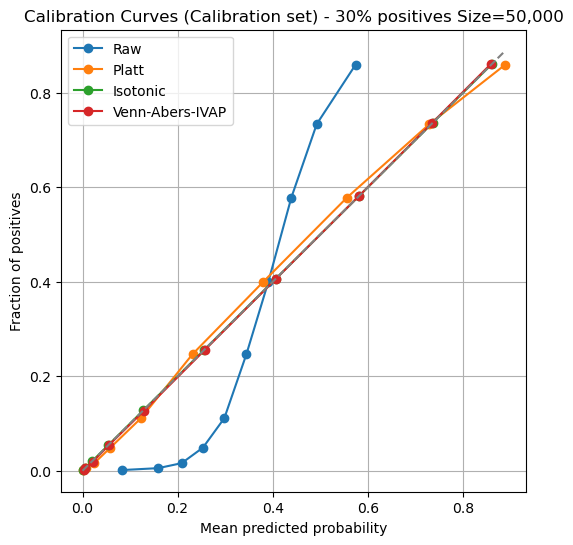

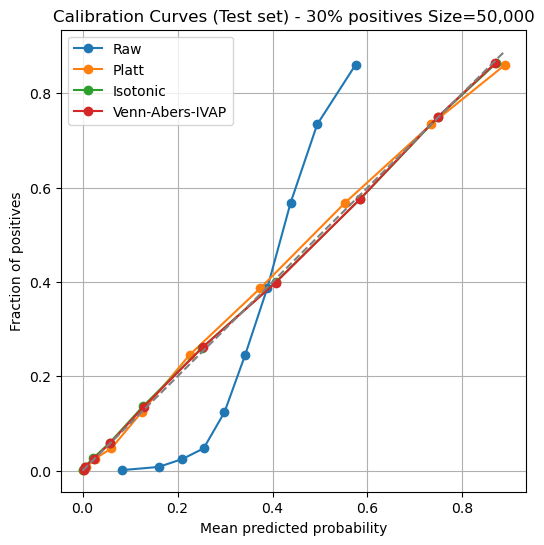

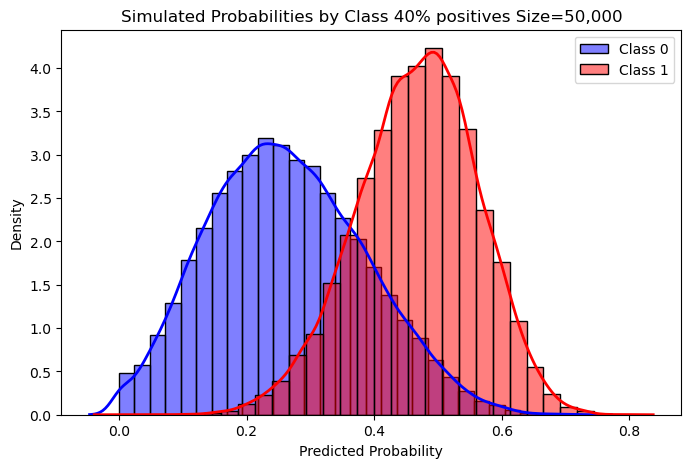


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5058,0.1676,0.9016,0.1804
Platt,0.3860,0.1242,0.9016,0.0100
Isotonic,0.3836,0.1236,0.9021,0.0000
Venn-Abers-IVAP,0.3839,0.1236,0.9021,0.0013



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5076,0.1676,0.9021,0.1829
Platt,0.3868,0.1239,0.9021,0.0112
Isotonic,0.3865,0.1240,0.9019,0.0073
Venn-Abers-IVAP,0.3847,0.1240,0.9019,0.0073


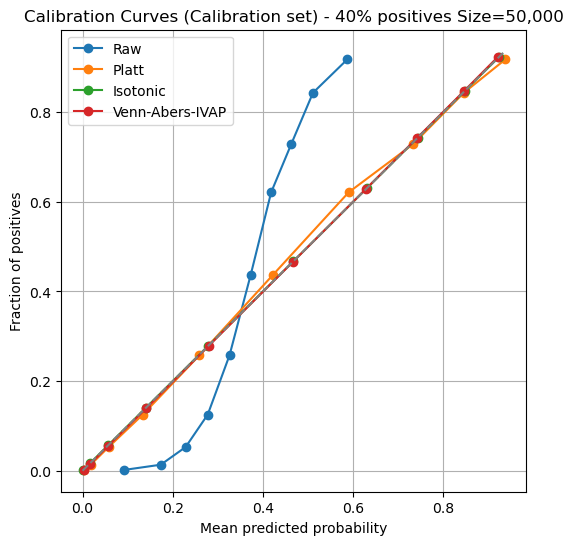

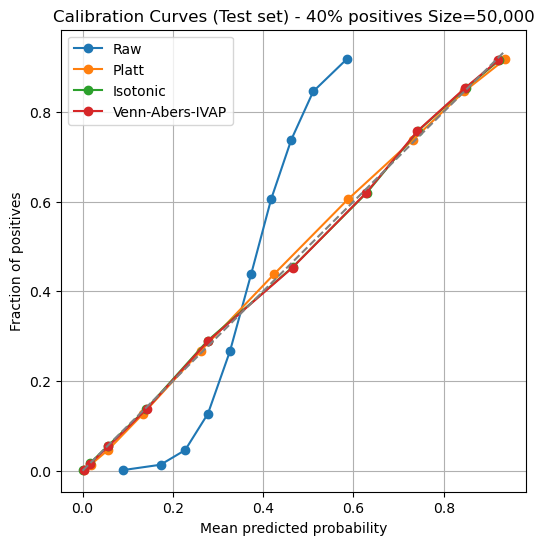

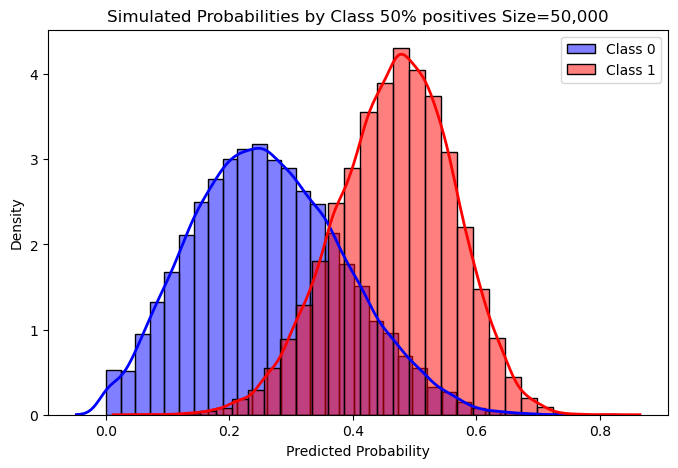


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5511,0.1880,0.9033,0.2208
Platt,0.3889,0.1235,0.9033,0.0113
Isotonic,0.3859,0.1228,0.9039,0.0000
Venn-Abers-IVAP,0.3862,0.1229,0.9039,0.0014



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5532,0.1892,0.8999,0.2202
Platt,0.3947,0.1256,0.8999,0.0143
Isotonic,0.3936,0.1256,0.8997,0.0093
Venn-Abers-IVAP,0.3935,0.1255,0.8997,0.0089


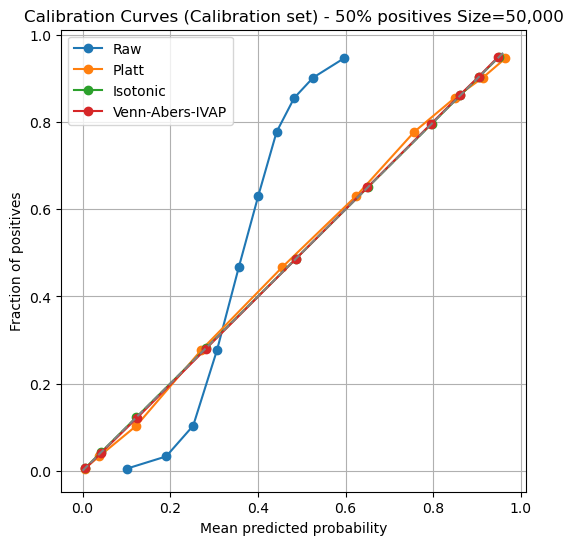

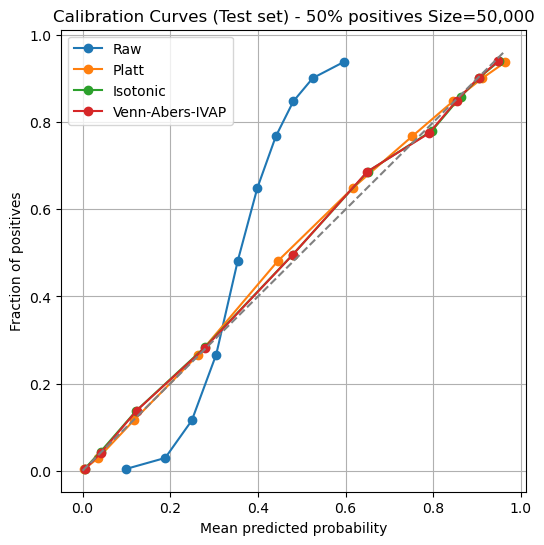

In [43]:
# Size of dataset: 50,000 samples
run_simulation({0: 47500, 1: 2500}, title="5% positives Size=50,000")

run_simulation({0: 45000, 1: 5000}, title="10% positives Size=50,000")

run_simulation({0: 40000, 1: 10000}, title="20% positives Size=50,000")

run_simulation({0: 35000, 1: 15000}, title="30% positives Size=50,000")

run_simulation({0: 30000, 1: 20000}, title="40% positives Size=50,000")

run_simulation({0: 25000, 1: 25000}, title="50% positives Size=50,000")